# <center> LSTM Model Training --- Seattle

## 1. Data Loading 

In [1]:
# Download the Data from Google Drive
import gdown
import pandas as pd

In [2]:
# Save data to the temporary folder
merged_data_file_id = '1o_EEumVnswul9MVsrdDwBch5rt7JTr0m'
merged_data_url = f'https://drive.google.com/uc?id={merged_data_file_id}'
merged_data_filepath = '../../temporary_files/merged.csv'
gdown.download(merged_data_url, merged_data_filepath, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1o_EEumVnswul9MVsrdDwBch5rt7JTr0m
To: c:\Users\Steven\Documents\Projects\ss24-capstone-team23-datallah-nkitts-steveso\temporary_files\merged.csv
100%|██████████| 438k/438k [00:00<00:00, 6.96MB/s]


'../../temporary_files/merged.csv'

In [3]:
# Load merged data into DataFrame
merged_df = pd.read_csv(merged_data_filepath)
city_data = merged_df[merged_df['City'] == 'Seattle'].reset_index(drop=True)

## 2. Feature Importance Analysis

In [5]:
# Import packages for Feature Importance Analysis
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin

In [6]:
# Preprocess the data for LSTM
def preprocess_data(df, window=12):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Custom wrapper class for Keras model
class KerasRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, build_fn, epochs=50, batch_size=32):
        self.build_fn = build_fn
        self.epochs = epochs
        self.batch_size = batch_size
        self.model = None

    def fit(self, X, y):
        self.model = self.build_fn()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0)
        return self

    def predict(self, X):
        return self.model.predict(X).flatten()

# Function to create LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [7]:
# Preprocess and split the data
window_size = 3
X_train, y_train, X_test, y_test, scaler = preprocess_data(city_data, window=window_size)

# Wrap the Keras model
keras_regressor = KerasRegressor(build_fn=create_lstm_model, epochs=50, batch_size=32)
keras_regressor.fit(X_train, y_train)

# Flatten the test set for permutation importance
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# Define a custom scoring function
def custom_scorer(model, X, y):
    X_reshaped = X.reshape(-1, window_size, X.shape[1] // window_size)
    y_pred = model.predict(X_reshaped).flatten()
    return -mean_squared_error(y, y_pred)  # Negate the MSE for permutation_importance compatibility

perm_importance = permutation_importance(keras_regressor, X_test_flat, y_test, n_repeats=10, random_state=0, scoring=custom_scorer)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

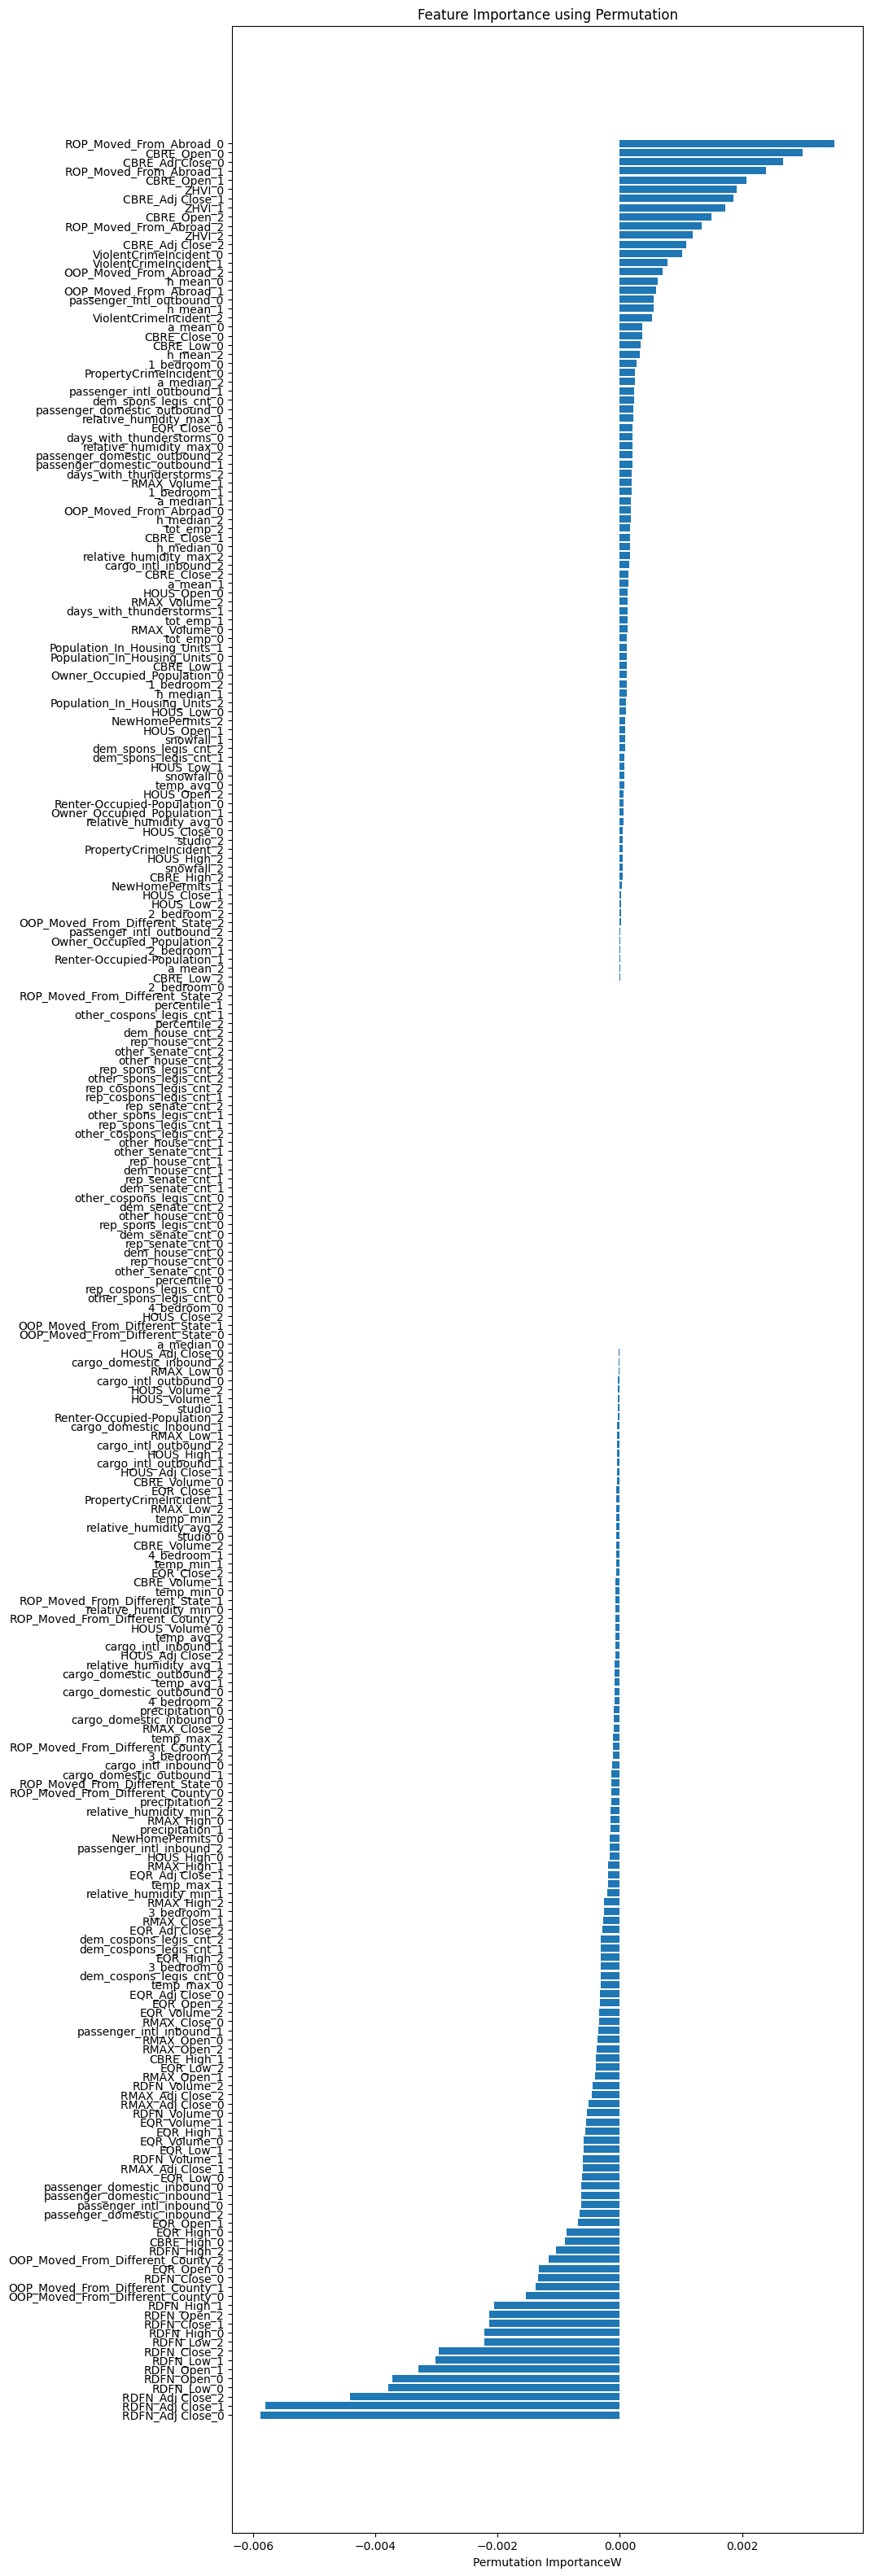

In [8]:
# Plot feature importance
sorted_idx = perm_importance.importances_mean.argsort()

# Generate feature names for the flattened input
original_feature_names = city_data.columns.drop(['Date', 'City']).tolist()
feature_names = [f"{feature}_{i}" for i in range(window_size) for feature in original_feature_names]

# Plot the feature importance results
plt.figure(figsize=(10, 40)) 
plt.barh(np.array(feature_names)[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation ImportanceW")
plt.title("Feature Importance using Permutation")
plt.show()

In [9]:
# Aggregate permutation importance scores for each feature across the three windows
aggregated_importance = {}
for feature in original_feature_names:
    aggregated_importance[feature] = sum(
        perm_importance.importances_mean[i] for i in range(len(feature_names)) if feature in feature_names[i]
    )

# Get the top 3 contributing features
sorted_features = sorted(aggregated_importance.items(), key=lambda x: x[1], reverse=True)
top_5_features = sorted_features[:5]

features_to_use = []
# Print the top 3 contributing features
print("Top 5 contributing features based on permutation importance:")
for feature, importance in top_5_features:
    print(f"{feature}: {importance}")
    if(feature != 'ZHVI'):
        features_to_use.append(feature)

Top 5 contributing features based on permutation importance:
ROP_Moved_From_Abroad: 0.007240821003657125
CBRE_Open: 0.0065783530635811875
CBRE_Adj Close: 0.005624010607577609
ZHVI: 0.0048383977404572705
ViolentCrimeIncident: 0.0023448899189398324


In [10]:
# Only keep the important features for HyperParameterTunning
requried_columns = ['City', 'Date', 'ZHVI']
selected_features = requried_columns + features_to_use
selected_features_city_df = city_data[selected_features]

# Reorganize to make sure ZHVI is the first column
columns = selected_features_city_df.columns.tolist()
columns.insert(0, columns.pop(columns.index('ZHVI')))
selected_features_city_df = selected_features_city_df[columns]

selected_features_city_df.columns

Index(['ZHVI', 'City', 'Date', 'ROP_Moved_From_Abroad', 'CBRE_Open',
       'CBRE_Adj Close', 'ViolentCrimeIncident'],
      dtype='object')

In [11]:
selected_features_city_df

,ZHVI,City,Date,ROP_Moved_From_Abroad,CBRE_Open,CBRE_Adj Close,ViolentCrimeIncident
0,333469.123267,Seattle,2010-01-01,26185,13.81,12.30,794.0
1,331798.116973,Seattle,2010-02-01,25755,12.49,13.20,708.0
2,329912.684266,Seattle,2010-03-01,25325,13.26,15.85,814.0
3,329622.476597,Seattle,2010-04-01,24895,16.02,17.32,813.0
4,329849.475555,Seattle,2010-05-01,24465,17.53,15.83,920.0
...,...,...,...,...,...,...,...
151,766046.523988,Seattle,2022-08-01,31535,84.69,78.96,1215.0
152,750100.759481,Seattle,2022-09-01,31535,78.26,67.51,1162.0
153,738608.017450,Seattle,2022-10-01,31535,68.66,70.94,1171.0
154,731683.657028,Seattle,2022-11-01,31535,72.11,79.60,987.0


## 3. Model Training

In [12]:
def preprocess_data(df, window=3):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Function to create and train LSTM
def create_and_train_lstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

    return model, history

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

In [13]:
results = {}

# Use Window size 3 as we know it's the best
X_train, y_train, X_test, y_test, scaler = preprocess_data(selected_features_city_df, window=3)

# Train the model
model, history = create_and_train_lstm(X_train, y_train, epochs=300, batch_size=32)

# Make predictions
lstm_preds = make_predictions(model, X_test, scaler)
actual_vals = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
actual_vals = actual_vals[:, 0]

# Calculate MSE
mse = mean_squared_error(actual_vals, lstm_preds)
results = {'mse': mse, 'predictions': lstm_preds, 'actuals': actual_vals, 'history':history}
print(f'Seattle - MSE: {mse:.2f}')

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - loss: 0.1231 - val_loss: 0.6643
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0894 - val_loss: 0.5277
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0643 - val_loss: 0.3918
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0347 - val_loss: 0.2607
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0254 - val_loss: 0.1466
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0194 - val_loss: 0.0815
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0233 - val_loss: 0.0659
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0237 - val_loss: 0.0807
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0194 - val_loss: 0.1140
Epoch 10/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0154 - val_loss: 0.1454
Epoch 11/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0142 - val_loss: 0.1649
Epoch 12/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0148 - val_l

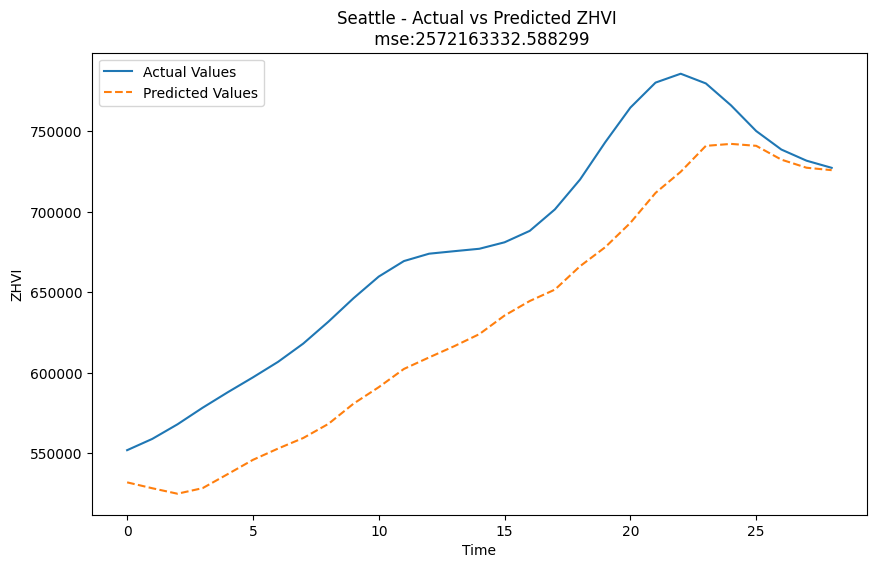

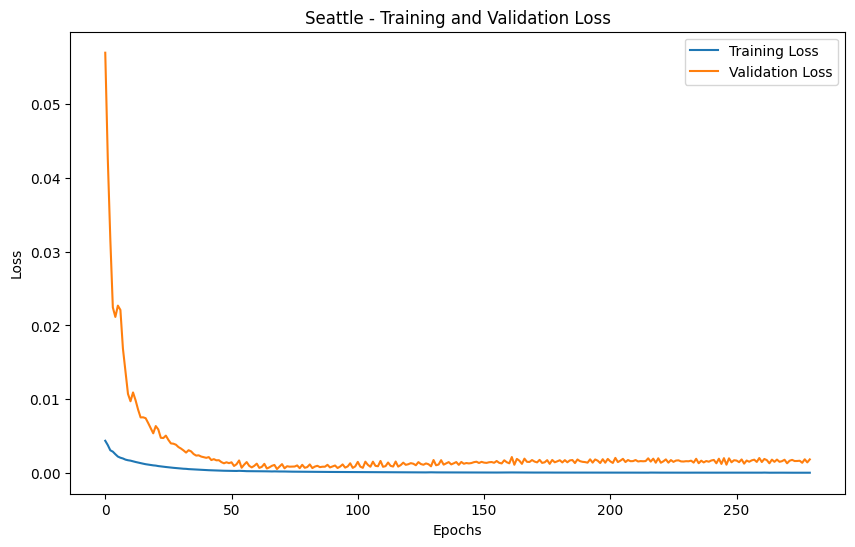

In [14]:

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(results['actuals'], label='Actual Values')
plt.plot(results['predictions'], label='Predicted Values', linestyle='--')
plt.title(f"Seattle - Actual vs Predicted ZHVI \n mse:{results['mse']}")
plt.xlabel('Time')
plt.ylabel('ZHVI')
plt.legend()
plt.show()

# Plotting loss curves
plt.figure(figsize=(10, 6))
plt.plot(results['history'].history['loss'][20:], label='Training Loss')
plt.plot(results['history'].history['val_loss'][20:], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Seattle - Training and Validation Loss")
plt.show()

## 4. HyperParameters Tuning
Use Random Search to find out what are the best hyper parameters to use

In [15]:
# Import packages for Feature Importance Analysis
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers  import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.base import BaseEstimator, RegressorMixin
from kerastuner.tuners import RandomSearch
import shutil


C:\Users\Steven\AppData\Local\Temp\ipykernel_13068\2951440225.py:14: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [16]:
# Function to preprocess the data
def preprocess_data(df, window=3):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Preprocess data
X_train, y_train, X_test, y_test, scaler = preprocess_data(selected_features_city_df, window=3)

# Build model function
def build_model(hp):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=hp.Int('units_layer1', min_value=30, max_value=100, step=10),
                   return_sequences=True,
                   kernel_regularizer=l2(0.001)))
    model.add(LSTM(units=hp.Int('units_layer2', min_value=30, max_value=100, step=10),
                   kernel_regularizer=l2(0.001)))
    model.add(Dropout(rate=hp.Float('dropout_layer', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(1, kernel_regularizer=l2(0.001)))
   
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='mean_squared_error', 
                  metrics=['mean_squared_error'])
    return model

# Create tuner
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error', 
    max_trials=20,
    executions_per_trial=2,
    directory='hyperparam_tuning',
    project_name='lstm_tuning_seattle')

# Define early stopping
early_stopping = EarlyStopping(monitor='val_mean_squared_error', patience=20, restore_best_weights=True)

# Run the tuner search with early stopping
tuner.search(X_train, y_train, epochs=200, validation_split=0.2, callbacks=[early_stopping])

Trial 20 Complete [00h 00m 29s]
val_mean_squared_error: 0.01693656062707305

Best val_mean_squared_error So Far: 0.00021532701794058084
Total elapsed time: 00h 06m 58s


In [17]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
print(f"Units Layer 1: {best_hyperparameters.get('units_layer1')}")
print(f"Units Layer 2: {best_hyperparameters.get('units_layer2')}")
print(f"Dropout Layer 1: {best_hyperparameters.get('dropout_layer')}")
print(f"Learning Rate: {best_hyperparameters.get('learning_rate')}")

Best Hyperparameters:
Units Layer 1: 90
Units Layer 2: 100
Dropout Layer 1: 0.1
Learning Rate: 0.0033554068733104474


In [18]:
trials = tuner.oracle.get_best_trials(num_trials=10)
trial_data = []

for trial in trials:
    trial_data.append({
        'units_layer1': trial.hyperparameters.values['units_layer1'],
        'units_layer2': trial.hyperparameters.values['units_layer2'],
        'dropout_layer2': trial.hyperparameters.values['dropout_layer'],
        'learning_rate': trial.hyperparameters.values['learning_rate'],
        'val_mean_squared_error': trial.metrics.get_best_value('val_mean_squared_error')
    })

trial_df = pd.DataFrame(trial_data)
print("\nTop 10 Hyperparameter Combinations:")
trial_df


Top 10 Hyperparameter Combinations:


,units_layer1,units_layer2,dropout_layer2,learning_rate,val_mean_squared_error
0,90,100,0.1,0.003355,0.000215
1,30,90,0.1,0.001280,0.000231
2,100,40,0.2,0.002770,0.000244
3,80,80,0.1,0.002095,0.000251
4,50,100,0.2,0.000842,0.000274
5,90,80,0.1,0.004114,0.000297
6,80,90,0.1,0.001258,0.000307
7,70,30,0.2,0.002647,0.000469
8,40,100,0.1,0.003223,0.000475
9,70,70,0.5,0.001006,0.000503


In [20]:
trial_df.to_csv('Results/Seattle/RandomSearchResult.csv', index=False)

## 4. Train a model with best HyperParameters

In [39]:
# Function to process the data
def preprocess_data(df, window=3):
    split_index = int(len(df) * 0.8)
    train_df = df.iloc[:split_index]
    test_df = df.iloc[split_index:]

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_df.drop(['Date', 'City'], axis=1))
    test_scaled = scaler.transform(test_df.drop(['Date', 'City'], axis=1))

    X_train, y_train = [], []
    for i in range(window, len(train_scaled)):
        X_train.append(train_scaled[i-window:i])
        y_train.append(train_scaled[i, 0])  # ZHVI is the first column

    X_test, y_test = [], []
    for i in range(window, len(test_scaled)):
        X_test.append(test_scaled[i-window:i])
        y_test.append(test_scaled[i, 0])  # ZHVI is the first column

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), scaler

# Function to create and train LSTM
def create_and_train_lstm(X_train, y_train, epochs=100, batch_size=32):
    model = Sequential()
    model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=100, return_sequences=True, kernel_regularizer=l2(0.001)))
    model.add(LSTM(units=100, return_sequences=False, kernel_regularizer=l2(0.001)))
    model.add(Dropout(0.1)) 
    model.add(Dense(1, kernel_regularizer=l2(0.001)))
    model.compile(optimizer='adam', loss='mean_squared_error')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=10, min_lr=0.00001)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, callbacks=[reduce_lr, early_stopping])

    return model, history

# Function to make predictions and inverse scale them
def make_predictions(model, X, scaler):
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(np.hstack((predictions, np.zeros((predictions.shape[0], X.shape[2] - 1)))))
    return predictions[:, 0]  # Only return the ZHVI predictions

In [43]:
model_results = {}

# Use Window size 3 as we know it's the best
X_train, y_train, X_test, y_test, scaler = preprocess_data(selected_features_city_df, window=3)

# Train the model
model, history = create_and_train_lstm(X_train, y_train, epochs=300, batch_size=32)

# Make predictions
lstm_preds = make_predictions(model, X_test, scaler)
actual_vals = scaler.inverse_transform(np.hstack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], X_test.shape[2] - 1)))))
actual_vals = actual_vals[:, 0]

# Calculate MSE
mse = mean_squared_error(actual_vals, lstm_preds)
model_results = {'mse': mse, 'predictions': lstm_preds, 'actuals': actual_vals, 'history':history}
print(f'Seattle - MSE: {mse:.2f}')

Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 146ms/step - loss: 0.2828 - val_loss: 0.7074 - learning_rate: 0.0010
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2210 - val_loss: 0.4737 - learning_rate: 0.0010
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1818 - val_loss: 0.2817 - learning_rate: 0.0010
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1569 - val_loss: 0.1825 - learning_rate: 0.0010
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1546 - val_loss: 0.1679 - learning_rate: 0.0010
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1437 - val_loss: 0.1963 - learning_rate: 0.0010
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1288 - val_loss: 0.2420 - learning_rate: 0.0010
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1182 - val_loss: 0.2725 - learning_rate: 0.0010
Epoch 9/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1143 - val_loss: 0.2623 - learning_rate: 0.0010
Epoch 10/300
3/3 ━━━━━━━━━━

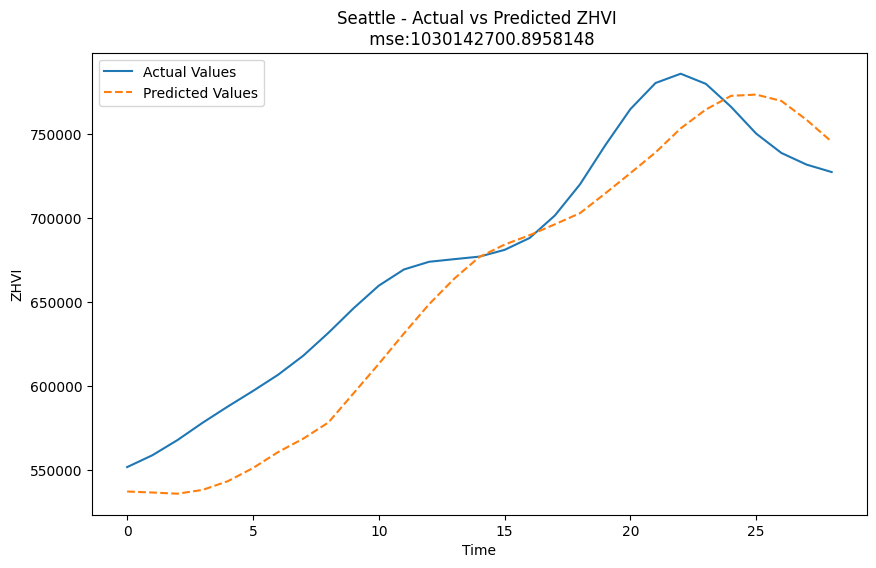

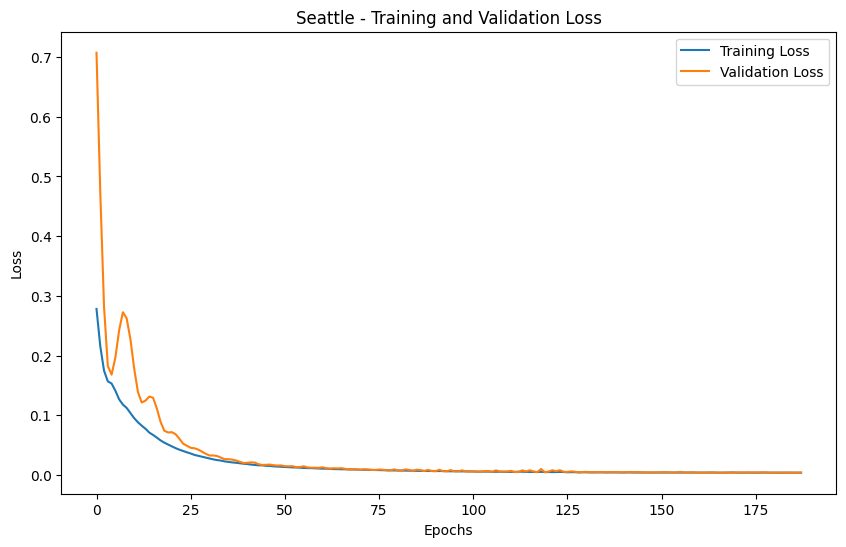

In [44]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(model_results['actuals'], label='Actual Values')
plt.plot(model_results['predictions'], label='Predicted Values', linestyle='--')
plt.title(f"Seattle - Actual vs Predicted ZHVI \n mse:{model_results['mse']}")
plt.xlabel('Time')
plt.ylabel('ZHVI')
plt.legend()
plt.show()

# Plotting loss curves
plt.figure(figsize=(10, 6))
plt.plot(model_results['history'].history['loss'], label='Training Loss')
plt.plot(model_results['history'].history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title(f"Seattle - Training and Validation Loss")
plt.show()

In [45]:
# Save the model results
import pickle
import numpy as np

# Define file paths
model_filepath = 'Results/Seattle/lstm_model.keras'
history_filepath = 'Results/Seattle/training_history.pkl'
actual_vals_filepath = 'Results/Seattle/actual_vals.npy'
predict_vals_filepath = 'Results/Seattle/lstm_predict_vals.npy'

# Save the model
model.save(model_filepath)

# Save the history
with open(history_filepath, 'wb') as f:
    pickle.dump(history.history, f)

# Save actual values and predicted values
np.save(actual_vals_filepath, actual_vals)
np.save(predict_vals_filepath, lstm_preds)

# 5. Performance Evaluation

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

with open('Results/lstm_baseline_mse.json', 'r') as json_file:
    lstm_baseline_mse = json.load(json_file)

with open('Results/lstm_baseline_prediction.json', 'r') as json_file:
    lstm_baseline_prediction = json.load(json_file)

with open('Results/mean_baseline_mse.json', 'r') as json_file:
    mean_baseline_mse = json.load(json_file)

with open('Results/mean_baseline_prediction.json', 'r') as json_file:
    mean_baseline_prediction = json.load(json_file)

actual_zhvi = np.load('Results/Seattle/actual_vals.npy')
lstm_prediction =  np.load('Results/Seattle/lstm_predict_vals.npy')

In [5]:
lstm_baseline_mse = lstm_baseline_mse['Seattle']
lstm_baseline_prediction = lstm_baseline_prediction['Seattle']
mean_baseline_mse = mean_baseline_mse['Seattle']
mean_baseline_prediction = mean_baseline_prediction['Seattle']


Final LSTM MSE: 1030142700.90
Improvement over LSTM baseline MSE: 21491624798.28 (95.43%)
Improvement over mean baseline MSE: -537912154.83 (-109.28%)


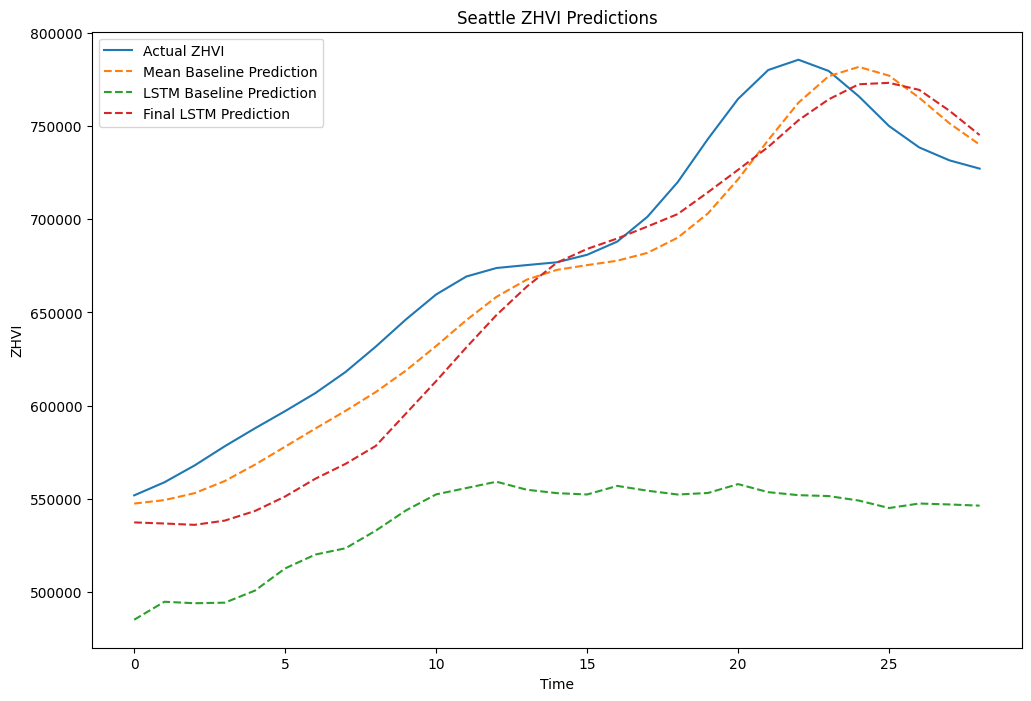

In [6]:
# Calculate the MSE for the final LSTM prediction
final_lstm_mse = mean_squared_error(actual_zhvi, lstm_prediction)

# Calculate the improvement in MSE
improvement_lstm_baseline = lstm_baseline_mse - final_lstm_mse
improvement_mean_baseline = mean_baseline_mse - final_lstm_mse

# Calculate the percentage improvement
improvement_lstm_baseline_percent = (improvement_lstm_baseline / lstm_baseline_mse) * 100
improvement_mean_baseline_percent = (improvement_mean_baseline / mean_baseline_mse) * 100

print(f'Final LSTM MSE: {final_lstm_mse:.2f}')
print(f'Improvement over LSTM baseline MSE: {improvement_lstm_baseline:.2f} ({improvement_lstm_baseline_percent:.2f}%)')
print(f'Improvement over mean baseline MSE: {improvement_mean_baseline:.2f} ({improvement_mean_baseline_percent:.2f}%)')

# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(actual_zhvi, label='Actual ZHVI')
plt.plot(mean_baseline_prediction, label='Mean Baseline Prediction', linestyle='--')
plt.plot(lstm_baseline_prediction, label='LSTM Baseline Prediction', linestyle='--')
plt.plot(lstm_prediction, label='Final LSTM Prediction', linestyle='--')
plt.title('Seattle ZHVI Predictions')
plt.xlabel('Time')
plt.ylabel('ZHVI')
plt.legend()
plt.show()